<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [29]:
#Import necessary modules for Google Colab to mount Google Drive and authenticate user
from google.colab import drive
from google.colab import auth

#Mount Google Drive and authenticate user to access Google services
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated


#Load Packages

In [30]:
#Import necessary packages for Google BigQuery and data processing
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

#Install and import the geoip2 package for geolocation
!pip install geoip2
import geoip2.database

#Import additional packages for time management, machine learning, and data scaling
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


# Connect to Big Query and Get Data

In [31]:
#Set up Google BigQuery client with the specified project ID
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)
#Fraud cases - (TC40/Safe -  run the model against Fraud cases only)!

#Query to select fraud and non-fraud cases from the dataset
Query = """
Select distinct * from (
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)
union all
Select * from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (
Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id not in (Select distinct Clientinfo_id from `Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Clientinfo_id in (SELECT distinct Clientinfo_id FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` where Is_fraud is not null)) limit 5000))
where Clientinfo_email not like ('%fibonatix.com') and Clientinfo_email not like ('%@fibonaitx.com');
"""
#@fibonaitx.com
#perv limit:12869
#Validation set 2024
#Execute the query and convert the results to a Pandas DataFrame
Query_Results = bigquery_client.query(Query)
Data_Adf = Query_Results.to_dataframe()

#Remove duplicate records based on the 'id' column
Data_Adf = Data_Adf.drop_duplicates(subset=['id'])
Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud
0,2271269,Mwj4Nyba,6ZiiA1Dl,297.000000000,237.830000000,2601:246:4501:2bb0:69fc:1252:5fc:bf2d,2021-02-08 09:09:43+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
1,2146699,BqJLi297,jBLTyqo8,57.000000000,45.640000000,2600:387:a:982::23,2021-01-13 09:44:17+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
2,1996092,VzFJMZ37,2gWHeRaw,67.000000000,53.650000000,2607:fb90:f52e:a74b:238f:b880:ca57:e768,NaT,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
3,2248621,1FgYdMCW,QpqjIC46,67.000000000,53.650000000,98.102.136.42,2021-02-03 03:34:35+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
4,2139134,bfwRnoMW,iqYISO6g,67.000000000,53.650000000,2600:387:c:721a::9,2021-01-12 09:39:12+00:00,None,None,<NA>,...,16,7299,Miscellaneous Personal Services (Not Elsewhere...,2022-11-13 15:47:50+00:00,NaT,<NA>,None,NaT,NaT,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28430,7956224,kGqkOoL0,jazCQPCo,34.190000000,29.310000000,94.238.126.75,2023-04-10 13:24:09+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,FR
28431,10655984,JuuWePRz,cmnUtqMl,39.430000000,33.840000000,2a01:e0a:a93:33d0:bd75:aaa3:8805:5b10,2024-01-20 01:03:24+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,FR
28432,9794433,Q0e2OeBP,KFBedOxu,30.000000000,25.750000000,89.205.130.189,2023-10-19 19:16:12+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None
28433,10093409,FGhh7PxP,6gGQYjeC,49.290000000,42.300000000,2a02:85f:f0c4:3f00:e5ac:f612:1ba5:e76,2023-11-23 07:00:04+00:00,None,None,<NA>,...,4,5499,Miscellaneous Food Stores – Convenience Stores...,2022-11-13 15:38:59+00:00,NaT,<NA>,None,NaT,NaT,None


#Check whether there are any duplicate ID's

In [32]:
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]
duplicate_rows

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_id,MCCs_code,MCCs_description,MCCs_updated_at,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Is_fraud


In [33]:
# Check for emails ending with "fibonatix.com" or "@fibonaitx.com"
mask_fibonatix = Data_Adf['Clientinfo_email'].str.endswith('fibonatix.com')
mask_fibonaitx = Data_Adf['Clientinfo_email'].str.endswith('fibonaitx.com')

# Combine both masks
mask = mask_fibonatix | mask_fibonaitx

# Filter DataFrame
filtered_df = Data_Adf[mask]

# Check if any such emails exist
if not filtered_df.empty:
    print("Emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.")
    print(filtered_df)
else:
    print("No emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.")


No emails ending with 'fibonatix.com' or 'fibonaitx.com' exist in the DataFrame.


#Conversion and Creation of Variables

In [34]:
#Function to convert columns to float type
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

#Function to convert columns to string type
def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

#Define columns to be converted to string and float
columns_to_string = ['id']
columns_to_float = ['amount_gbp']

#Convert specified columns to float and string types
convert_float(columns_to_float)
convert_string(columns_to_string)

#Replace 'None' with a placeholder value & map string values to boolean values
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].fillna('Missing')
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].map({'Missing': False, 'FR': True})

#Data Analysis

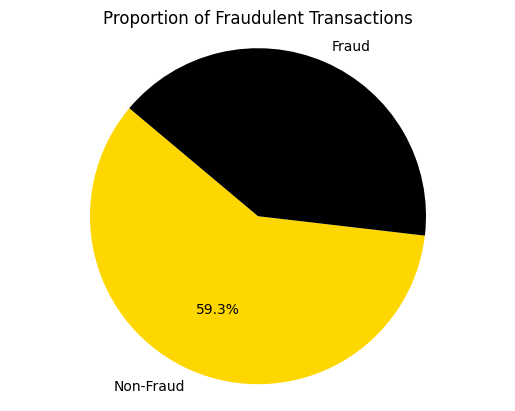

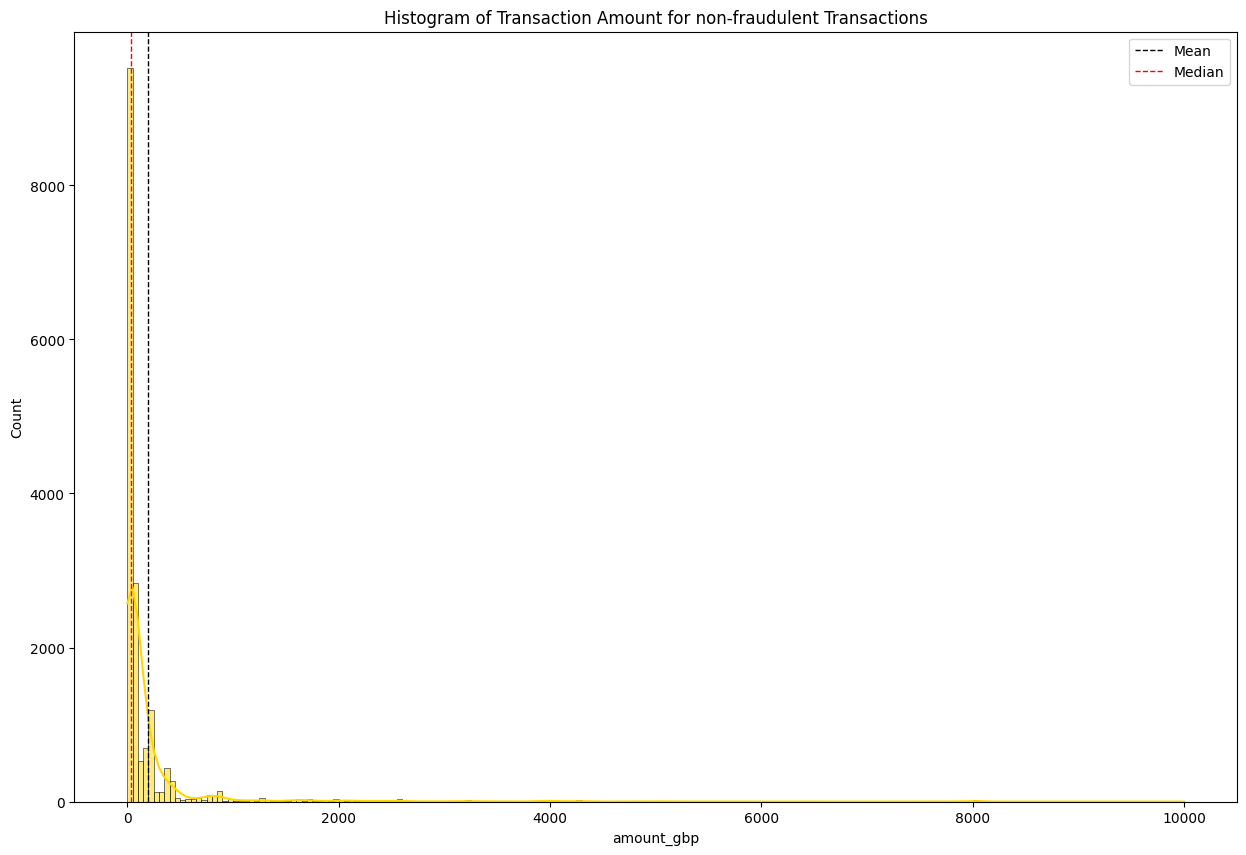

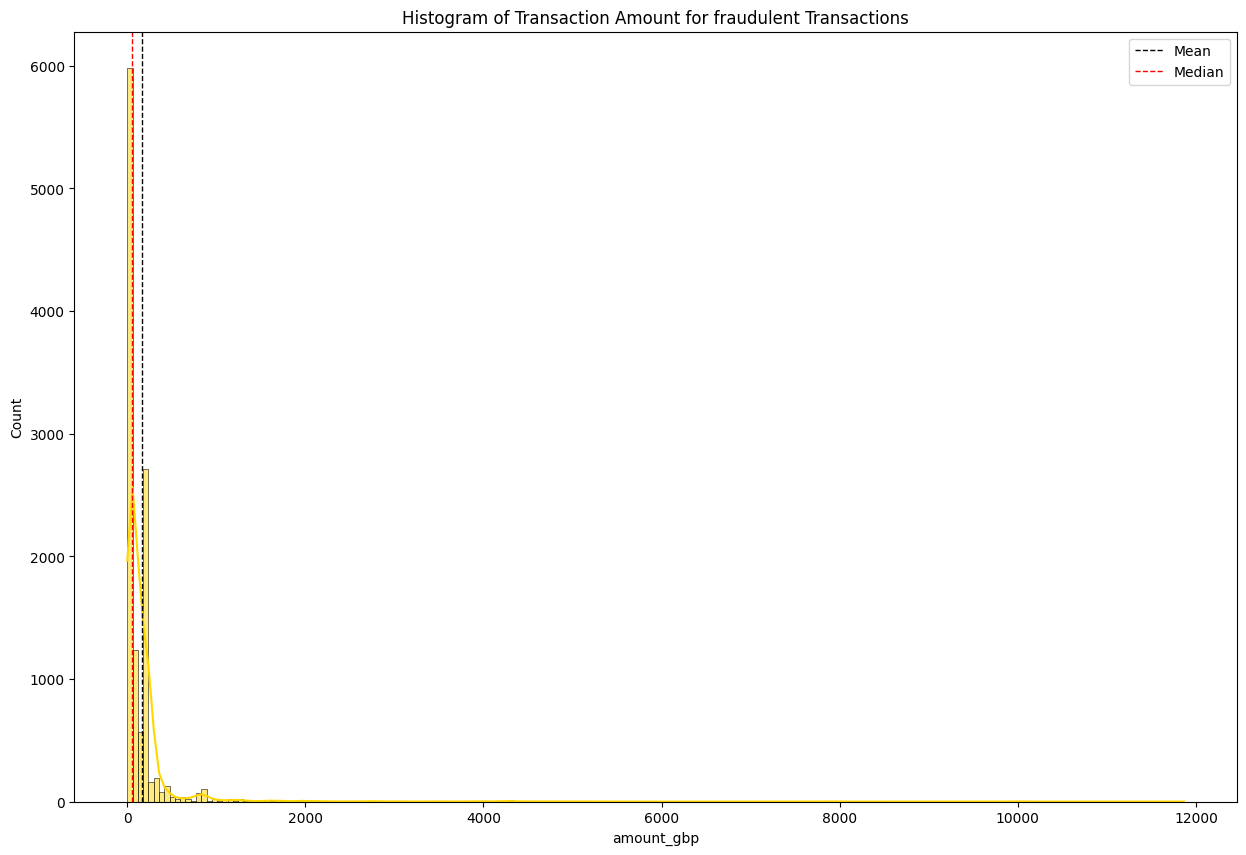

In [35]:
#Visualization of share of fraudulent vs. non-fraudulent transactions (trx) using a pie chart
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check the amount distribution of fraudulent vs. non-fraudulent trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Plotting of histogram of transaction amount for non-fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for non-fraudulent Transactions")
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Plotting of histogram of transaction amount for fraudulent transactions
plt.figure(figsize=(15,10))
plt.title("Histogram of Transaction Amount for fraudulent Transactions")
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black', bins=200)
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [36]:
#Calcualte Customer Profile Statistics: mean, median and standard deviation of transaction amount per client
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']

#Calcualte Average Number of trx per day per customer
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge datasets to combine customer profile statistics
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.650,53.650,1.0
1,1058557,53.650,53.650,1.0
2,1058568,157.750,157.750,1.0
3,1058569,157.750,157.750,1.0
4,1058596,137.735,137.735,1.0
...,...,...,...,...
15341,4635591,356.690,356.690,1.0
15342,4636096,31.230,31.230,1.0
15343,4636365,76.060,76.060,1.0
15344,4636424,78.680,78.680,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [37]:
#Function to get country information from an IP address
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#Read country latitude and longitude data from a CSV file
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')

In [38]:
#Get Customer Device IP coordinates (country) and use get_country function to get country information
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

#Merge country information with latitude and longitude data
merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

,id,client_id,latitude_ip,longitude_ip
0,2271269,1227732,NaN,NaN
1,2146699,1172713,NaN,NaN
2,1996092,1060280,NaN,NaN
3,2248621,1221357,NaN,NaN
4,2139134,1172161,NaN,NaN
...,...,...,...,...
28429,7956224,2585803,46.227638,2.213749
28430,10655984,4284960,46.227638,2.213749
28431,9794433,2936381,52.132633,5.291266
28432,10093409,3676222,39.074208,21.824312


In [39]:
#Get customer card issuer bank coordinates (country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()

#Fill NaN values with 0 and rename column for consistency
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)

#Merge country information with latitude and longitude data
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')

#Select relevant columns and rename them
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,2271269,1227732,NaN,NaN
1,2146699,1172713,NaN,NaN
2,1996092,1060280,NaN,NaN
3,2248621,1221357,NaN,NaN
4,2139134,1172161,NaN,NaN
...,...,...,...,...
28429,7956224,2585803,46.227638,2.213749
28430,10655984,4284960,46.227638,2.213749
28431,9794433,2936381,52.132633,5.291266
28432,10093409,3676222,39.074208,21.824312


In [40]:
#Merge country profiles based on ID
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,how = 'left', on='id')

#Select relevant columns and rename them
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns
old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
2271269,1227732,NaN,NaN,NaN,NaN
2146699,1172713,NaN,NaN,NaN,NaN
1996092,1060280,NaN,NaN,NaN,NaN
2248621,1221357,NaN,NaN,NaN,NaN
2139134,1172161,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7956224,2585803,46.227638,2.213749,46.227638,2.213749
10655984,4284960,46.227638,2.213749,46.227638,2.213749
9794433,2936381,52.132633,5.291266,52.132633,5.291266


# Get Transaction Profile (Trx_Profile)

In [41]:
#Function to convert time to seconds
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

#Function to check if a date is a weekend
def is_weekend(date):
    return date.weekday() >= 5

#Function to calculate client spending behavior features over various rolling window sizes of customer transactions
def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

#Get is_night feature
Trx_Profile.loc[:,'hour'] = Trx_Profile['timestamp'].dt.hour
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['hour'] >= 22) | (Trx_Profile['hour'] < 4)
Trx_Profile.loc[:,'is_night?'] = Trx_Profile.loc[:,'is_night?'].astype(int)

#Drop unnecessary columns and rename
columns_to_drop = ['time','date','hour']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}
Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

#Set 'id' column as index and convert it to integer type
Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
2271269,2021-02-08 09:09:43+00:00,1227732,237.83,32983,0,0
2146699,2021-01-13 09:44:17+00:00,1172713,45.64,35057,0,0
1996092,2021-01-04 09:31:18+00:00,1060280,53.65,34278,0,0
2248621,2021-02-03 03:34:34+00:00,1221357,53.65,12874,0,1
2139134,2021-01-12 09:39:12+00:00,1172161,53.65,34752,0,0
...,...,...,...,...,...,...
7956224,2023-04-10 13:24:09+00:00,2585803,29.31,48249,0,0
10655984,2024-01-20 01:03:25+00:00,4284960,33.84,3805,1,1
9794433,2023-10-19 19:16:13+00:00,2936381,25.75,69373,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [42]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

#Convert timestamp to datetime without timezone
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and client ID
Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate customer spending behavior features
%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

#Set 'id' column as index and convert it to integer type
Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 11s, sys: 1.32 s, total: 1min 13s
Wall time: 1min 14s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983596,2021-01-01 01:57:49,1058596,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11570155,2024-04-28 21:57:57,4636096,31.23,1.0,31.23,1.0,31.23,1.0,31.23
11570906,2024-04-29 03:16:30,4636365,76.06,1.0,76.06,1.0,76.06,1.0,76.06
11571067,2024-04-29 04:57:32,4636424,78.68,1.0,78.68,1.0,78.68,1.0,78.68


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [43]:
#Function to calculate spending behavior features of a brand over various rolling window sizes of customer transactions
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].shift(1).rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].shift(1).rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

#Create a new column for fraudulent transaction amounts
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

#Extract relevant columns for Brand Fraud Profile
Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

#Convert timestamp to datetime without timezone
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

#Sort the DataFrame by timestamp and brand ID
Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

#Apply the previously defined function to calculate brand fraud profile features
%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

#Set 'id' column as index and convert it to integer type
Brand_Fraud_Profile.set_index('id',inplace=True)
Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

#Drop the 'amount_gbp_fraud_trx' column
Brand_Fraud_Profile = Brand_Fraud_Profile.drop('amount_gbp_fraud_trx', axis=1)
Brand_Fraud_Profile

CPU times: user 1.36 s, sys: 16.5 ms, total: 1.38 s
Wall time: 1.38 s


,timestamp,Brands_id,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,
1989686,2021-01-02 18:18:00,1234,0.0,NaN,0.0,NaN,0.0,NaN
1995031,2021-01-04 02:07:19,1234,1.0,53.65,1.0,53.65,1.0,53.65
1999498,2021-01-04 21:42:57,1234,1.0,53.65,1.0,53.65,1.0,53.65
2001827,2021-01-05 09:31:50,1234,1.0,157.75,2.0,105.70,2.0,105.70
2103691,2021-01-06 21:50:25,1234,1.0,53.65,3.0,88.35,3.0,88.35
...,...,...,...,...,...,...,...,...
11400649,2024-04-10 07:43:35,851555,0.0,NaN,0.0,NaN,0.0,NaN
11482171,2024-04-18 13:28:25,851555,1.0,213.50,1.0,213.50,1.0,213.50
11344183,2024-04-04 14:11:58,851558,0.0,NaN,0.0,NaN,0.0,NaN


In [44]:
abc = Trx_Profile_Rolling.copy()
xyz = Brand_Fraud_Profile.copy()

abc = abc.reset_index(level='id') #Key is id
xyz = xyz.reset_index(level='id') #Key is id

# Convert 'id' column to sets for faster comparison
id_set1 = set(abc['id'])
id_set2 = set(xyz['id'])

# Find missing IDs in df2
missing_ids = id_set1 - id_set2

print("Missing IDs in df2:", missing_ids)


Missing IDs in df2: set()


# Get All Dummy Variables (Data_Dummies)

In [45]:
#Creating a copy of the original data frame with the needed columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()

#Extract email domain
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating dummy variables for categorical columns, dropping email column and converting columns to integer type
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

# Set 'id' column as index
Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_MYR,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
2271269,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2146699,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1996092,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2248621,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2139134,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7956224,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10655984,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9794433,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Merge all Datasets into a Single Dataset

In [46]:
#Rest indexs in all dataframes in preparation to merge
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id

In [47]:
#Extract fraud flag column and convert to integer type
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag.loc[:, 'id'] = DF_Flag['id'].astype(int)
DF_Flag.loc[:, 'Is_fraud'] = DF_Flag['Is_fraud'].astype(int)

#Add the previously newly created attributes to the id and fraud flag dataset with a merge
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

##only when Testing With Full Dataset

In [48]:
#Add the dummies dataset with a merge
DF5 = pd.merge(DF4, Data_Dummies, how='left', on='id')

##only when Testing Without Profiles

In [49]:
#Merge the previously newly created dummy variables to the id and fraud flag dataset with a merge
DF_x = pd.merge(Data_Dummies, DF_Flag, how='left', on='id')

# Balancing Dataset

In [50]:
#Selecting subset with fraudulent and non-fraudulent trx and removing duplicate rows based on the 'id' column
#For Testing Without Dummies & Coordinates (_wodc)
ones_subset_wodc = DF4.loc[DF4["Is_fraud"] == 1]
zeros_subset_wodc = DF4.loc[DF4["Is_fraud"] == 0]
#For Testing Without Profiles (_wop)
ones_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 1]
zeros_subset_wop = DF_x.loc[DF_x["Is_fraud"] == 0]
#For Testing With Full Dataset (_fd)
ones_subset_fd = DF5.loc[DF5["Is_fraud"] == 1]
zeros_subset_fd = DF5.loc[DF5["Is_fraud"] == 0]

#Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones_wodc = len(ones_subset_wodc)
sampled_zeros_wodc = zeros_subset_wodc.sample(number_of_ones_wodc, random_state=42)
number_of_ones_wop = len(ones_subset_wop)
sampled_zeros_wop = zeros_subset_wop.sample(number_of_ones_wop, random_state=42)
number_of_ones_fd = len(ones_subset_fd)
sampled_zeros_fd = zeros_subset_fd.sample(number_of_ones_fd, random_state=42)

#Concatenate the sampled null values with the non-null values
balanced_df_wodc = pd.concat([ones_subset_wodc, sampled_zeros_wodc], ignore_index=True)
balanced_df_wop = pd.concat([ones_subset_wop, sampled_zeros_wop], ignore_index=True)
balanced_df_fd = pd.concat([ones_subset_fd, sampled_zeros_fd], ignore_index=True)

#Copy Dataset & account for Null Values
DS_wodc = balanced_df_wodc.copy()
DS_wodc.replace('<NA>', np.nan, inplace=True)
DS_wop = balanced_df_wop.copy()
DS_wop.replace('<NA>', np.nan, inplace=True)
DS_fd = balanced_df_fd.copy()
DS_fd.replace('<NA>', np.nan, inplace=True)

#Splitting into Training, Test, and Validation Set

In [51]:
# Define the start and end dates for each split
train_start_date = '1970-01-01'
train_end_date = '2023-10-31'
test_start_date = '2023-11-01'
test_end_date = '2024-01-31'
val_start_date = '2024-02-01'
val_end_date = DS_wodc['timestamp'].max()

##Only run one of the following three:

###when Testing With Full Dataset

In [55]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_fd['timestamp'] = pd.to_datetime(DS_fd['timestamp'])

# Perform the split based on timestamp
train_set = DS_fd[(DS_fd['timestamp'] >= train_start_date) & (DS_fd['timestamp'] <= train_end_date)]
test_set = DS_fd[(DS_fd['timestamp'] >= test_start_date) & (DS_fd['timestamp'] <= test_end_date)]
val_set = DS_fd[(DS_fd['timestamp'] >= val_start_date) & (DS_fd['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

Train set length: 18648
Test set length: 2446
Validation set length: 2007
Train set after dropping columns:        latitude_ip  longitude_ip  latitude_card  longitude_card  Is_fraud  \
0              NaN           NaN            NaN             NaN         1   
1              NaN           NaN            NaN             NaN         1   
2              NaN           NaN            NaN             NaN         1   
3              NaN           NaN            NaN             NaN         1   
4              NaN           NaN            NaN             NaN         1   
...            ...           ...            ...             ...       ...   
23157    14.058324    108.277199      14.058324      108.277199         0   
23158    37.090240    -95.712891     -30.559482       22.937506         0   
23161   -40.900557    174.885971     -40.900557      174.885971         0   
23162    61.924110     25.748151      58.595272       25.013607         0   
23163          NaN           NaN            N

###when Testing Without Dummies & Coordinates

In [53]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wodc['timestamp'] = pd.to_datetime(DS_wodc['timestamp'])

# Perform the split based on timestamp
train_set = DS_wodc[(DS_wodc['timestamp'] >= train_start_date) & (DS_wodc['timestamp'] <= train_end_date)]
test_set = DS_wodc[(DS_wodc['timestamp'] >= test_start_date) & (DS_wodc['timestamp'] <= test_end_date)]
val_set = DS_wodc[(DS_wodc['timestamp'] >= val_start_date) & (DS_wodc['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp'] + ['latitude_ip']+ ['longitude_ip']+ ['latitude_card']+ ['longitude_card']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

Train set length: 18648
Test set length: 2446
Validation set length: 2007
Train set after dropping columns:        Is_fraud  trx_time_seconds  trx_is_weekend  is_night?  amount_gbp  \
0             1             32983               0          0      237.83   
1             1             35057               0          0       45.64   
2             1             34278               0          0       53.65   
3             1             12874               0          1       53.65   
4             1             34752               0          0       53.65   
...         ...               ...             ...        ...         ...   
23157         0             52475               0          0       30.86   
23158         0                68               0          1       76.00   
23161         0             34391               1          0      350.00   
23162         0             70567               0          0       68.35   
23163         0             49155               0       

###when Testing Without Profiles

In [54]:
# Convert the "timestamp" column to datetime if it's not already in datetime format
DS_wop['timestamp'] = pd.to_datetime(DS_wop['timestamp'])

# Perform the split based on timestamp
train_set = DS_wop[(DS_wop['timestamp'] >= train_start_date) & (DS_wop['timestamp'] <= train_end_date)]
test_set = DS_wop[(DS_wop['timestamp'] >= test_start_date) & (DS_wop['timestamp'] <= test_end_date)]
val_set = DS_wop[(DS_wop['timestamp'] >= val_start_date) & (DS_wop['timestamp'] <= val_end_date)]

# Check the lengths of each set
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))
print("Validation set length:", len(val_set))

#Gather columns containing ID's, timestamps and others to drop in a list and drop them to prepare the final dataframe
column_ids = [col for col in train_set.columns if '_id' in col]
column_timestamp = [col for col in train_set.columns if 'timestamp' in col]
dropcolumns = column_ids + column_timestamp + ['id']

# Apply the same drop operation to all sets
train = train_set.drop(columns=dropcolumns)
test = test_set.drop(columns=dropcolumns)
val = val_set.drop(columns=dropcolumns)

# Print or use these DataFrames as needed
print("Train set after dropping columns:", train)
print("Test set after dropping columns:", test)
print("Validation set after dropping columns:", val)

KeyError: 'timestamp'

#Define y and X variables

In [56]:
# Define y and X variables for train, test, and val sets
y_train, X_train = train['Is_fraud'], train.drop(columns=['Is_fraud'])
y_test, X_test = test['Is_fraud'], test.drop(columns=['Is_fraud'])
y_val, X_val = val['Is_fraud'], val.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_val = X_val.fillna(0)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Logistic Regression Model

In [57]:
# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test_pca)

# Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Predict on the validation set
y_val_pred = model.predict(X_val_pca)

# Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1199  261]
 [ 147  839]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1460
           1       0.76      0.85      0.80       986

    accuracy                           0.83      2446
   macro avg       0.83      0.84      0.83      2446
weighted avg       0.84      0.83      0.83      2446

Validation set evaluation:
[[1207  255]
 [ 132  413]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1462
           1       0.62      0.76      0.68       545

    accuracy                           0.81      2007
   macro avg       0.76      0.79      0.77      2007
weighted avg       0.82      0.81      0.81      2007



In [ ]:
#Define lists to store evaluation metrics
log_accuracy_list = []
log_precision_list = []
log_recall_list = []
log_f1_score_list = []

#Define a list of hyperparameters to try
hyperparameters = [
    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'tol': 1e-4},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'tol': 1e-3},
    {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'tol': 1e-4},
    {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'tol': 1e-4}
]

#Loop through each set of hyperparameters
for params in hyperparameters:
    #Initialize Logistic Regression model with custom hyperparameters
    model = LogisticRegression(random_state=42, max_iter=1000, **params)

    #Train the model
    model.fit(X_train_pca, y_train)

    #Predictions
    y_pred = model.predict(X_val_pca)

    #Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')

    #Append metrics to lists
    log_accuracy_list.append(accuracy)
    log_precision_list.append(precision)
    log_recall_list.append(recall)
    log_f1_score_list.append(f1_score)

#Plot the results
plt.figure(figsize=(12, 8))

#Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(range(len(hyperparameters)), log_accuracy_list, marker='o', linestyle='-', color='b')
plt.xticks(range(len(hyperparameters)), [str(params) for params in hyperparameters], rotation=45)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Hyperparameters')

#Precision plot
plt.subplot(2, 2, 2)
plt.plot(range(len(hyperparameters)), log_precision_list, marker='o', linestyle='-', color='g')
plt.xticks(range(len(hyperparameters)), [str(params) for params in hyperparameters], rotation=45)
plt.xlabel('Hyperparameters')
plt.ylabel('Precision')
plt.title('Precision vs. Hyperparameters')

#Recall plot
plt.subplot(2, 2, 3)
plt.plot(range(len(hyperparameters)), log_recall_list, marker='o', linestyle='-', color='r')
plt.xticks(range(len(hyperparameters)), [str(params) for params in hyperparameters], rotation=45)
plt.xlabel('Hyperparameters')
plt.ylabel('Recall')
plt.title('Recall vs. Hyperparameters')

#F1-score plot
plt.subplot(2, 2, 4)
plt.plot(range(len(hyperparameters)), log_f1_score_list, marker='o', linestyle='-', color='purple')
plt.xticks(range(len(hyperparameters)), [str(params) for params in hyperparameters], rotation=45)
plt.xlabel('Hyperparameters')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Hyperparameters')

plt.tight_layout()
plt.show()

In [58]:
#Get the coefficients of the logistic regression model
coefficients = model.coef_

#Get the principal components
components = pca.components_

#Map the coefficients back to the original features
feature_importance = np.dot(coefficients, components)

#Analyze the feature importance
feature_importance_abs = np.abs(feature_importance)
sorted_indices = np.argsort(feature_importance_abs)[0][::-1]  #Sort indices by absolute magnitude

#Print the top N features
top_n = 10  #Change this value according to your preference
for i in range(top_n):
    feature_index = sorted_indices[i]
    feature_name = X_train.columns[feature_index]  #Assuming X is a DataFrame
    importance_score = feature_importance[0][feature_index]
    print(f"Feature: {feature_name}, Importance Score: {importance_score}")


Feature: client_nb_trx_30day_window, Importance Score: -0.9636039667486205
Feature: brand_fraud_nb_trx_7day_window, Importance Score: 0.35954010790089713
Feature: brand_fraud_nb_trx_30day_window, Importance Score: 0.30876269191310124
Feature: brand_fraud_nb_trx_1day_window, Importance Score: 0.30512095435597963
Feature: client_nb_trx_7day_window, Importance Score: 0.19639889102410113
Feature: longitude_card, Importance Score: -0.1453422572875781
Feature: Processors_name_WLN, Importance Score: 0.14531680228341218
Feature: latitude_ip, Importance Score: -0.12454135027116321
Feature: Currency_name_USD, Importance Score: 0.11924886415575461
Feature: Industries_name_Online_Professional_Courses_Provider, Importance Score: 0.10506338682290352


In [59]:
#Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

#Get the indices of the top contributors
top_contributors_indices = np.argsort(explained_variance_ratio)[::-1][:10]

#Print the top contributors along with their percentages of variance explained
print("Top 10 Contributors:")
for i, idx in enumerate(top_contributors_indices):
    print(f"Component {i+1}: Variance Explained: {explained_variance_ratio[idx]*100:.2f}%")


Top 10 Contributors:
Component 1: Variance Explained: 36.36%
Component 2: Variance Explained: 25.57%
Component 3: Variance Explained: 16.09%
Component 4: Variance Explained: 9.04%
Component 5: Variance Explained: 2.18%
Component 6: Variance Explained: 1.92%
Component 7: Variance Explained: 1.18%
Component 8: Variance Explained: 0.90%
Component 9: Variance Explained: 0.81%
Component 10: Variance Explained: 0.76%


In [60]:
#Get the first principal component's eigenvector
first_component = pca.components_[0]

#Create a DataFrame to display the component along with their corresponding feature names
component_df = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': first_component})

#Sort the DataFrame by absolute component weights to visualize the most influential features
component_df['Absolute Weight'] = np.abs(component_df['Component Weight'])
component_df = component_df.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 1:")
print(component_df)


Components of Component 1:
                                   Feature  Component Weight  Absolute Weight
11           client_avg_amount_7day_window          0.405861         0.405861
9            client_avg_amount_1day_window          0.402374         0.402374
13          client_avg_amount_30day_window          0.401407         0.401407
20           cust_profiles_mean_gbp_amount          0.392602         0.392602
21         cust_profiles_median_gbp_amount          0.374586         0.374586
...                                    ...               ...              ...
2409               Issuers_name_PASHA_BANK         -0.000000         0.000000
1331         Email_domain_milelja-afroditi         -0.000000         0.000000
2414  Issuers_name_PAYONEER_EUROPE_LIMITED         -0.000000         0.000000
1325     Email_domain_melissamorganfineart         -0.000000         0.000000
1473                Email_domain_sympatico         -0.000000         0.000000

[2946 rows x 3 columns]


In [61]:
#Get the second principal component's eigenvector
second_component = pca.components_[1]

#Create a DataFrame to display the component along with their corresponding feature names
component_df2 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': second_component})

#Sort the DataFrame by absolute component weights to visualize the most influential features
component_df2['Absolute Weight'] = np.abs(component_df2['Component Weight'])
component_df2 = component_df2.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 2:")
print(component_df2)


Components of Component 2:
                                                Feature  Component Weight  \
1                                          longitude_ip          0.567097   
3                                        longitude_card          0.566341   
12                           client_nb_trx_30day_window          0.424764   
10                            client_nb_trx_7day_window          0.372836   
8                             client_nb_trx_1day_window          0.107912   
...                                                 ...               ...   
2282  Issuers_name_LANDSBANKI_ISLANDS_(NATIONAL_BANK...          0.000000   
841                    Deviceinfo_device_name_TMRV06P5G          0.000000   
838                    Deviceinfo_device_name_TECNO_KC8          0.000000   
2289                  Issuers_name_LOTTE_CARD_CO.,_LTD.          0.000000   
1473                             Email_domain_sympatico          0.000000   

      Absolute Weight  
1            0.567097  


In [62]:
#Get the third principal component's eigenvector
third_component = pca.components_[2]

#Create a DataFrame to display the component along with their corresponding feature names
component_df3 = pd.DataFrame({'Feature': X_train.columns, 'Component Weight': second_component})

#Sort the DataFrame by absolute component weights to visualize the most influential features
component_df3['Absolute Weight'] = np.abs(component_df3['Component Weight'])
component_df3 = component_df3.sort_values(by='Absolute Weight', ascending=False)

print("Components of Component 3:")
print(component_df3)

Components of Component 3:
                                                Feature  Component Weight  \
1                                          longitude_ip          0.567097   
3                                        longitude_card          0.566341   
12                           client_nb_trx_30day_window          0.424764   
10                            client_nb_trx_7day_window          0.372836   
8                             client_nb_trx_1day_window          0.107912   
...                                                 ...               ...   
2282  Issuers_name_LANDSBANKI_ISLANDS_(NATIONAL_BANK...          0.000000   
841                    Deviceinfo_device_name_TMRV06P5G          0.000000   
838                    Deviceinfo_device_name_TECNO_KC8          0.000000   
2289                  Issuers_name_LOTTE_CARD_CO.,_LTD.          0.000000   
1473                             Email_domain_sympatico          0.000000   

      Absolute Weight  
1            0.567097  


# Random Forest Model

In [91]:
#Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
model.fit(X_train_pca, y_train)

#Predict on the test set
y_test_pred = model.predict(X_test_pca)

#Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

#Predict on the validation set
y_val_pred = model.predict(X_val_pca)

#Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Test set evaluation:
[[1376   84]
 [ 104  882]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1460
           1       0.91      0.89      0.90       986

    accuracy                           0.92      2446
   macro avg       0.92      0.92      0.92      2446
weighted avg       0.92      0.92      0.92      2446

Validation set evaluation:
[[1371   91]
 [  75  470]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1462
           1       0.84      0.86      0.85       545

    accuracy                           0.92      2007
   macro avg       0.89      0.90      0.90      2007
weighted avg       0.92      0.92      0.92      2007



##Testing and comparing different Hyperparameters

In [146]:
#Define a list of n_estimators values
n_estimators_list = [80, 100, 200, 300, 350, 400, 500, 600]

#Define a list of max_depth values
max_depth_list = [10]

#Define lists to store evaluation metrics
accuracy_lists = [[] for _ in max_depth_list]
precision_lists = [[] for _ in max_depth_list]
recall_lists = [[] for _ in max_depth_list]
f1_score_lists = [[] for _ in max_depth_list]

for n_estimators in n_estimators_list:
    for i, max_depth in enumerate(max_depth_list):
        #Initialize and train the Random Forest model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train_pca, y_train)

        #Predictions on validation set
        y_val_pred = model.predict(X_val_pca)

        #Accuracy evaluation
        accuracy = accuracy_score(y_val, y_val_pred)
        accuracy_lists[i].append(accuracy)

        #Precision, recall, and F1-score evaluation
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro')
        precision_lists[i].append(precision)
        recall_lists[i].append(recall)
        f1_score_lists[i].append(f1_score)

##Plotting the results

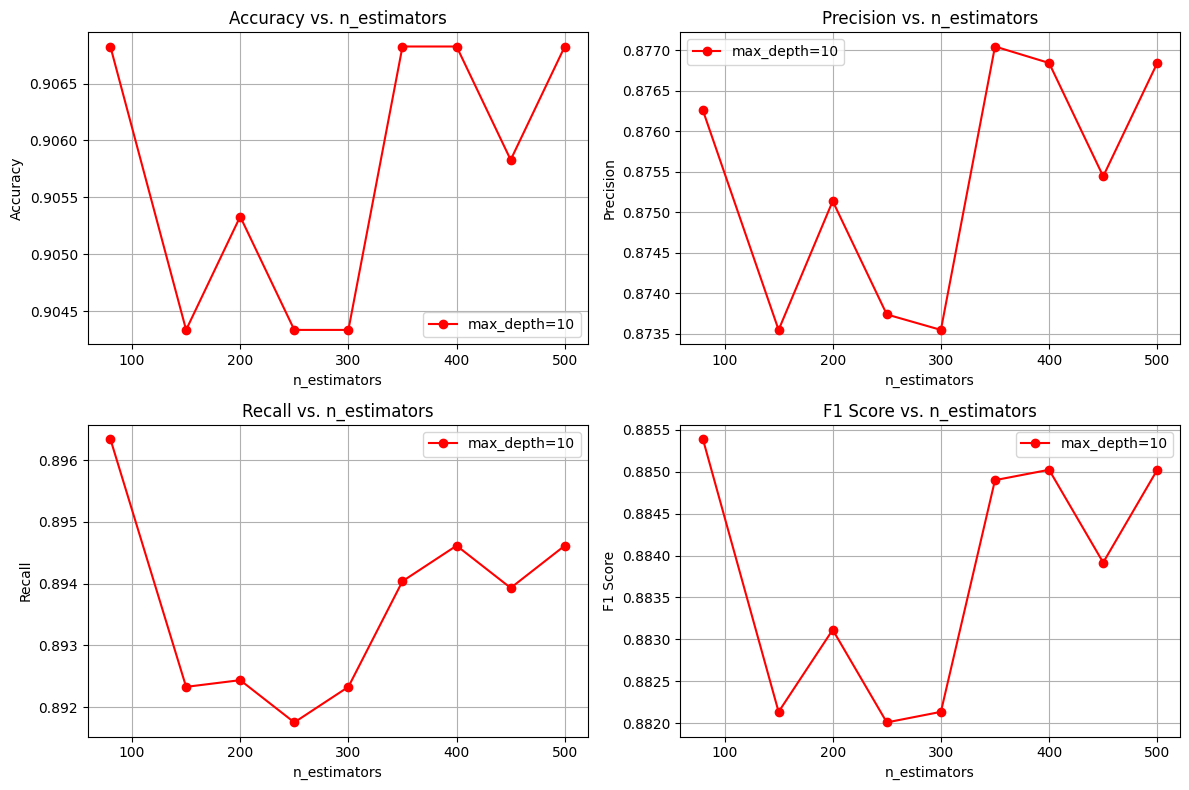

In [147]:
#Plot the results
plt.figure(figsize=(12, 8))

#Accuracy plot
plt.subplot(2, 2, 1)
for accuracy_list, max_depth, color in zip(accuracy_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, accuracy_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_estimators')
plt.legend()
plt.grid(True)

#Precision plot
plt.subplot(2, 2, 2)
for precision_list, max_depth, color in zip(precision_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, precision_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Precision')
plt.title('Precision vs. n_estimators')
plt.legend()
plt.grid(True)

#Recall plot
plt.subplot(2, 2, 3)
for recall_list, max_depth, color in zip(recall_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, recall_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Recall')
plt.title('Recall vs. n_estimators')
plt.legend()
plt.grid(True)

#F1 score plot
plt.subplot(2, 2, 4)
for f1_score_list, max_depth, color in zip(f1_score_lists, max_depth_list, ['r', 'g', 'b']):
    plt.plot(n_estimators_list, f1_score_list, marker='o', linestyle='-', color=color, label=f'max_depth={max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. n_estimators')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Neural Network Model

In [64]:
#Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_data=(X_val_pca, y_val), verbose=1)

#Predict on the test set
y_test_pred_proba = model.predict(X_test_pca)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

#Evaluate the model on the test set
print("Test set evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

#Predict on the validation set
y_val_pred_proba = model.predict(X_val_pca)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

#Evaluate the model on the validation set
print("Validation set evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Epoch 1/10
583/583 [==============================] - 6s 5ms/step - loss: 0.4138 - accuracy: 0.8271 - val_loss: 0.3854 - val_accuracy: 0.8226
Epoch 2/10
583/583 [==============================] - 2s 3ms/step - loss: 0.3697 - accuracy: 0.8413 - val_loss: 0.3699 - val_accuracy: 0.8316
Epoch 3/10
583/583 [==============================] - 2s 3ms/step - loss: 0.3586 - accuracy: 0.8446 - val_loss: 0.3098 - val_accuracy: 0.8834
Epoch 4/10
583/583 [==============================] - 2s 3ms/step - loss: 0.3558 - accuracy: 0.8460 - val_loss: 0.3033 - val_accuracy: 0.8744
Epoch 5/10
583/583 [==============================] - 2s 3ms/step - loss: 0.3479 - accuracy: 0.8481 - val_loss: 0.2895 - val_accuracy: 0.8869
Epoch 6/10
583/583 [==============================] - 2s 4ms/step - loss: 0.3466 - accuracy: 0.8500 - val_loss: 0.3329 - val_accuracy: 0.8630
Epoch 7/10
583/583 [==============================] - 3s 5ms/step - loss: 0.3421 - accuracy: 0.8517 - val_loss: 0.2751 - val_accuracy: 0.8929
Epoch 